In [1]:
import os

# Set environment variable to avoid memory leak issue on Windows with MKL
os.environ['OMP_NUM_THREADS'] = '3'

import pandas as pd
import holidays
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
import random
from scipy.signal import find_peaks

In [2]:
df = pd.read_csv('./data/dataset1.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [3]:
def date_segregation(date_string):
    formats_to_try = ["%m/%d/%Y %H:%M", "%Y/%m/%d %H:%M:%S"]
    for date_format in formats_to_try:
        try:
            # print(date_string)
            date_object = datetime.strptime(date_string, date_format)
            return date_object
        except ValueError:
            pass
    # If none of the formats match, return None or handle the error as appropriate
    return None

# Apply the function to convert Date column to timestamp
df[['timestamp']] = df['Read Date/Time'].apply(lambda x: pd.Series(date_segregation(x)))

In [4]:
df

,Meter ID,Read Date/Time,Read Value,attributes,timestamp
0,309079,1/1/2020 0:15,0.0725,"{""unit_of_measurement"": ""kWh""}",2020-01-01 00:15:00
1,309079,1/1/2020 0:30,0.0800,"{""unit_of_measurement"": ""kWh""}",2020-01-01 00:30:00
2,309079,1/1/2020 0:45,0.0745,"{""unit_of_measurement"": ""kWh""}",2020-01-01 00:45:00
3,309079,1/1/2020 1:00,0.0790,"{""unit_of_measurement"": ""kWh""}",2020-01-01 01:00:00
4,309079,1/1/2020 1:15,0.0755,"{""unit_of_measurement"": ""kWh""}",2020-01-01 01:15:00
...,...,...,...,...,...
601920,309082,3/31/2024 23:00,0.0390,"{""unit_of_measurement"": ""kWh""}",2024-03-31 23:00:00
601921,309082,3/31/2024 23:15,0.0600,"{""unit_of_measurement"": ""kWh""}",2024-03-31 23:15:00
601922,309082,3/31/2024 23:30,0.0465,"{""unit_of_measurement"": ""kWh""}",2024-03-31 23:30:00
601923,309082,3/31/2024 23:45,0.0640,"{""unit_of_measurement"": ""kWh""}",2024-03-31 23:45:00


In [5]:
# Calculate daily average load
# Combine load values of the same date and time together
data = df.groupby('timestamp', as_index=False)['Read Value'].sum()

# Extract date from timestamp
data['date'] = data['timestamp'].dt.date

daily_avg_load = data.groupby('date')['Read Value'].mean().reset_index()
daily_avg_load.columns = ['date', 'daily_avg']

# Merge daily average load back to the original data
data = data.merge(daily_avg_load, on='date')

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Prepare the data for K-means
features = data[['Read Value', 'daily_avg']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply K-means clustering
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)  # Assuming 2 clusters for simplicity
data['cluster'] = kmeans.fit_predict(features_scaled)


In [7]:
# Identify which cluster represents peaks
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
peak_cluster = cluster_centers[:, 0] > cluster_centers[:, 1]

# Assign a boolean for peaks
data['is_peak'] = data['cluster'] == peak_cluster.argmax()

# Filter out the peaks
peaks = data[data['is_peak']]

# Print peaks
print(peaks[['timestamp', 'Read Value', 'daily_avg']])

                 timestamp  Read Value  daily_avg
118    2020-01-02 05:45:00       0.379   0.488385
127    2020-01-02 08:00:00       0.406   0.488385
128    2020-01-02 08:15:00       0.641   0.488385
129    2020-01-02 08:30:00       0.679   0.488385
130    2020-01-02 08:45:00       0.717   0.488385
...                    ...         ...        ...
148759 2024-03-29 15:00:00       0.521   0.434708
148760 2024-03-29 15:15:00       0.537   0.434708
148761 2024-03-29 15:30:00       0.563   0.434708
148762 2024-03-29 15:45:00       0.496   0.434708
148763 2024-03-29 16:00:00       0.534   0.434708

[38386 rows x 3 columns]


In [8]:
data

,timestamp,Read Value,date,daily_avg,cluster,is_peak
0,2020-01-01 00:15:00,0.302,2020-01-01,0.340684,1,False
1,2020-01-01 00:30:00,0.353,2020-01-01,0.340684,1,False
2,2020-01-01 00:45:00,0.319,2020-01-01,0.340684,1,False
3,2020-01-01 01:00:00,0.352,2020-01-01,0.340684,1,False
4,2020-01-01 01:15:00,0.353,2020-01-01,0.340684,1,False
...,...,...,...,...,...,...
148983,2024-03-31 23:00:00,0.280,2024-03-31,0.297344,1,False
148984,2024-03-31 23:15:00,0.298,2024-03-31,0.297344,1,False
148985,2024-03-31 23:30:00,0.281,2024-03-31,0.297344,1,False
148986,2024-03-31 23:45:00,0.323,2024-03-31,0.297344,1,False


In [9]:
# Calculate the average load during peaky hours
peaky_load_avg = peaks.groupby('date')['Read Value'].mean().reset_index()
peaky_load_avg.columns = ['date', 'Workhour_avg_load']

# Calculate the average load during non-peaky hours
non_peak_hours = data[~data['is_peak']]
non_peaky_load_avg = non_peak_hours.groupby('date')['Read Value'].mean().reset_index()
non_peaky_load_avg.columns = ['date', 'Baseload']

# Drop existing Baseload and Workhour_avg_load columns if they exist
if 'Baseload' in data.columns:
    data.drop(columns=['Baseload'], inplace=True)
if 'Workhour_avg_load' in data.columns:
    data.drop(columns=['Workhour_avg_load'], inplace=True)

# Merge non-peak average load back to the original data
data = data.merge(non_peaky_load_avg, on='date', how='left')
data = data.merge(peaky_load_avg, on='date', how='left')

print("Average load during peaky hours:")
print(peaky_load_avg)
print("Average load during non-peaky hours:")
print(non_peaky_load_avg)

Average load during peaky hours:
            date  Workhour_avg_load
0     2020-01-02           0.792658
1     2020-01-03           0.922487
2     2020-01-06           0.875479
3     2020-01-07           0.890159
4     2020-01-08           0.639241
...          ...                ...
1097  2024-03-25           0.717353
1098  2024-03-26           0.693156
1099  2024-03-27           0.723361
1100  2024-03-28           0.710812
1101  2024-03-29           0.655722

[1102 rows x 2 columns]
Average load during non-peaky hours:
            date  Baseload
0     2020-01-01  0.340684
1     2020-01-02  0.289034
2     2020-01-03  0.249123
3     2020-01-04  0.254917
4     2020-01-05  0.244271
...          ...       ...
1494  2024-03-28  0.301344
1495  2024-03-29  0.302100
1496  2024-03-30  0.297417
1497  2024-03-31  0.297344
1498  2024-04-01  0.286000

[1499 rows x 2 columns]


In [ ]:
# Define a threshold factor
# threshold_factor = 1.1

# # Calculate the average load in a window around each data point
# window_size = 10  # You can adjust this window size
# peaks.loc[:,'avg_load_window'] = peaks['Read Value'].rolling(window=window_size, min_periods=1, center=True).mean()

# # Identify spikes as load values that exceed the threshold factor times the average load
# peaks.loc[:,'is_spike'] = peaks['Read Value'] > threshold_factor * peaks['avg_load_window']

# # Filter out the spikes
# spikes = peaks[peaks['is_spike']]

In [ ]:
# # Merge is_spike column back to data DataFrame based on matching dates
# data = pd.merge(data, peaks[['date', 'is_spike']], on='date', how='left')

# # Fill missing values in is_spike column with False
# data['is_spike'].fillna(False, inplace=True)

In [10]:
data

,timestamp,Read Value,date,daily_avg,cluster,is_peak,Baseload,Workhour_avg_load
0,2020-01-01 00:15:00,0.302,2020-01-01,0.340684,1,False,0.340684,NaN
1,2020-01-01 00:30:00,0.353,2020-01-01,0.340684,1,False,0.340684,NaN
2,2020-01-01 00:45:00,0.319,2020-01-01,0.340684,1,False,0.340684,NaN
3,2020-01-01 01:00:00,0.352,2020-01-01,0.340684,1,False,0.340684,NaN
4,2020-01-01 01:15:00,0.353,2020-01-01,0.340684,1,False,0.340684,NaN
...,...,...,...,...,...,...,...,...
148983,2024-03-31 23:00:00,0.280,2024-03-31,0.297344,1,False,0.297344,NaN
148984,2024-03-31 23:15:00,0.298,2024-03-31,0.297344,1,False,0.297344,NaN
148985,2024-03-31 23:30:00,0.281,2024-03-31,0.297344,1,False,0.297344,NaN
148986,2024-03-31 23:45:00,0.323,2024-03-31,0.297344,1,False,0.297344,NaN


In [36]:
start_idx = random.randint(0, len(data) - 14*24 - 1)
test = data.iloc[start_idx:start_idx + 14*24].copy()
test_peaks = test[test['is_peak']]

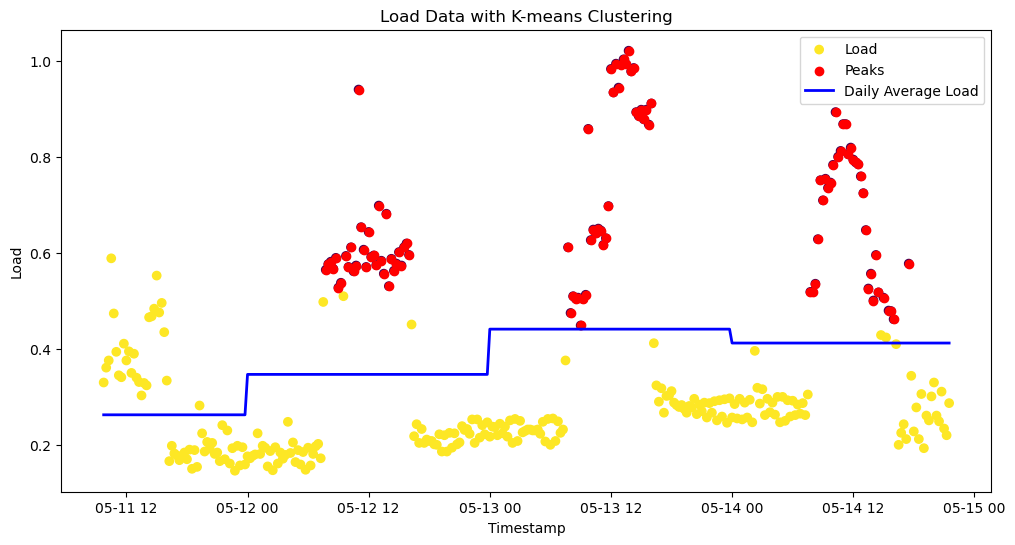

In [37]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.scatter(test['timestamp'], test['Read Value'], c=test['cluster'], cmap='viridis', label='Load')
plt.scatter(test_peaks['timestamp'], test_peaks['Read Value'], color='red', label='Peaks')
plt.plot(test['timestamp'], test['daily_avg'], color='blue', label='Daily Average Load', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Load')
plt.title('Load Data with K-means Clustering')
plt.legend()
plt.show()

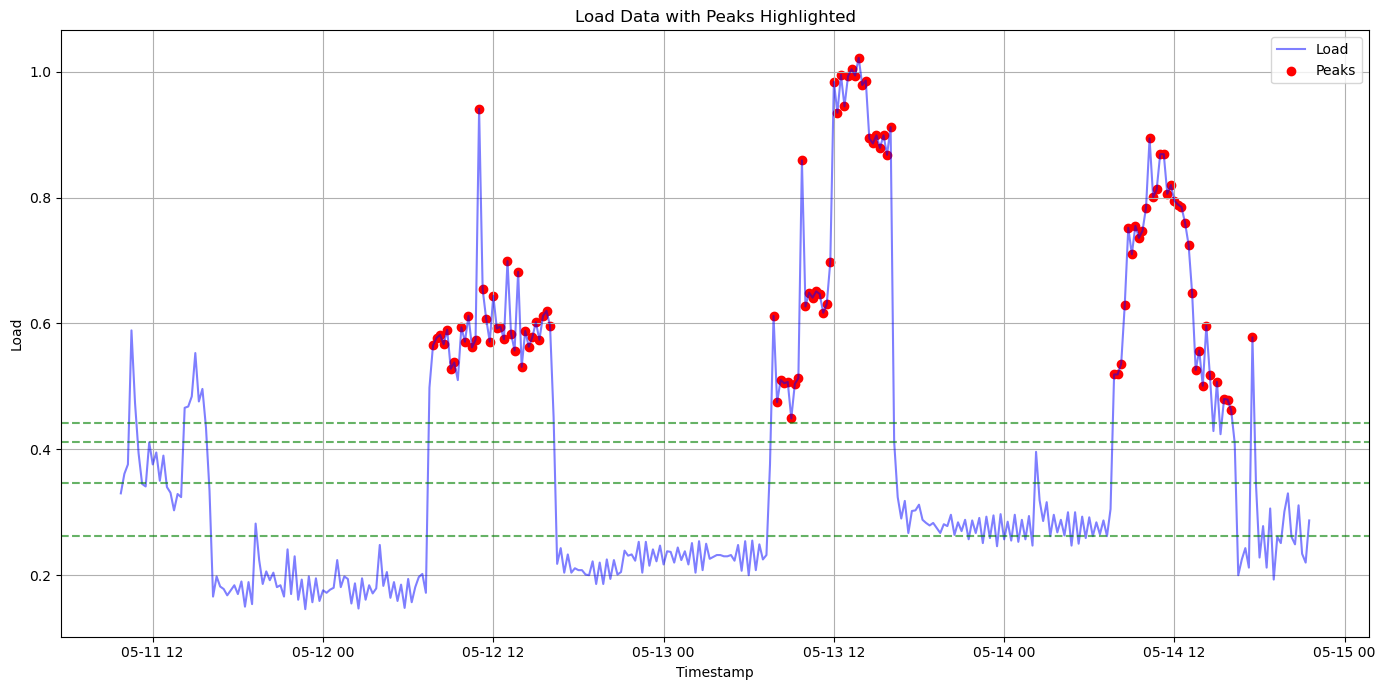

In [38]:
# Plotting the results for any two weeks
plt.figure(figsize=(14, 7))

# Plot the load
plt.plot(test['timestamp'], test['Read Value'], label='Load', color='blue', alpha=0.5)

# Highlight the peaks
plt.scatter(test_peaks['timestamp'], test_peaks['Read Value'], color='red', label='Peaks')

# Plot the daily average load
unique_dates = test['date'].unique()
for date in unique_dates:
    avg_load = test[test['date'] == date]['daily_avg'].iloc[0]
    plt.axhline(y=avg_load, color='green', linestyle='--', alpha=0.6)

# Formatting the plot
plt.title('Load Data with Peaks Highlighted')
plt.xlabel('Timestamp')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

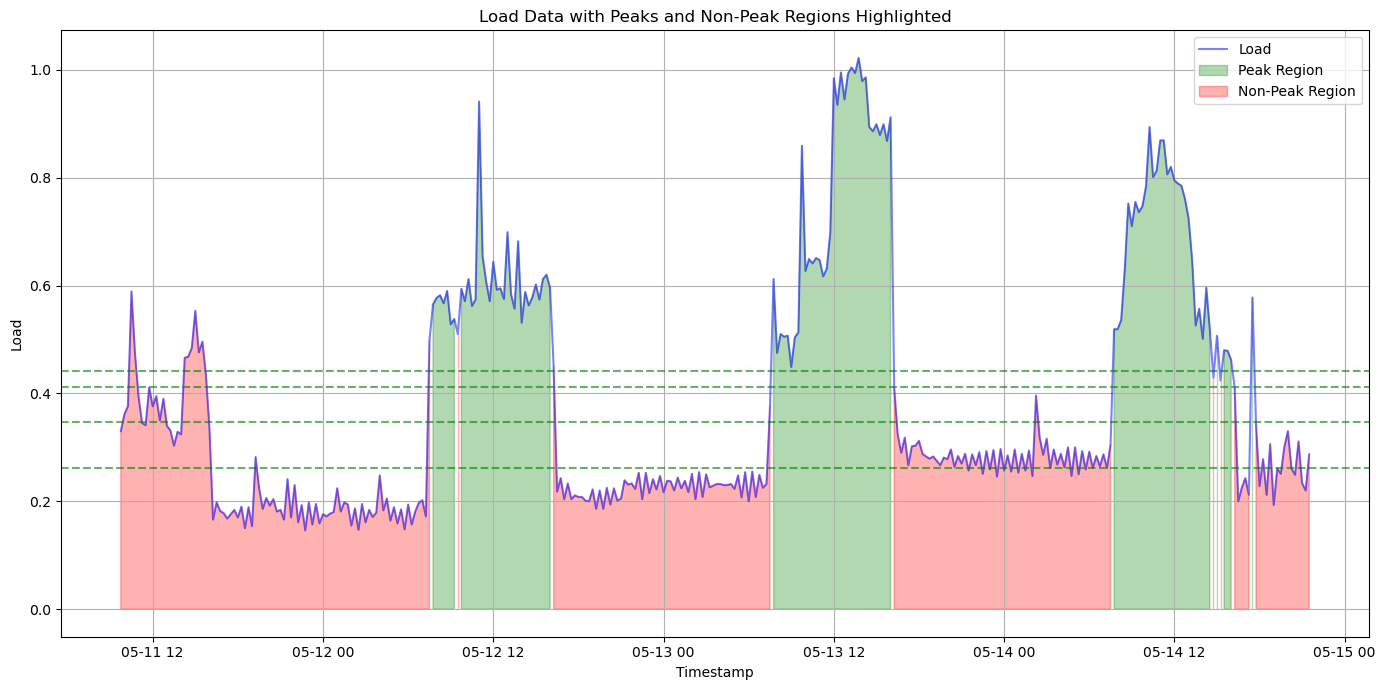

In [39]:
plt.figure(figsize=(14, 7))

# Plot the load
plt.plot(test['timestamp'], test['Read Value'], label='Load', color='blue', alpha=0.5)

# Highlight the area under the curve for peaks and non-peaks
plt.fill_between(test['timestamp'], 0, test['Read Value'], where=test['is_peak'], color='green', alpha=0.3, label='Peak Region')
plt.fill_between(test['timestamp'], 0, test['Read Value'], where=~test['is_peak'], color='red', alpha=0.3, label='Non-Peak Region')

# Plot the daily average load
unique_dates = test['date'].unique()
for date in unique_dates:
    avg_load = test[test['date'] == date]['daily_avg'].iloc[0]
    plt.axhline(y=avg_load, color='green', linestyle='--', alpha=0.6)

# Formatting the plot
plt.title('Load Data with Peaks and Non-Peak Regions Highlighted')
plt.xlabel('Timestamp')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

C:\Users\shshakya\AppData\Local\Temp\ipykernel_8488\820644132.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_peaks['avg_load_window'] = test_peaks['Read Value'].rolling(window=window_size, min_periods=1, center=True).mean()
C:\Users\shshakya\AppData\Local\Temp\ipykernel_8488\820644132.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_peaks['is_spike'] = test_peaks['Read Value'] > threshold_factor * test_peaks['avg_load_window']


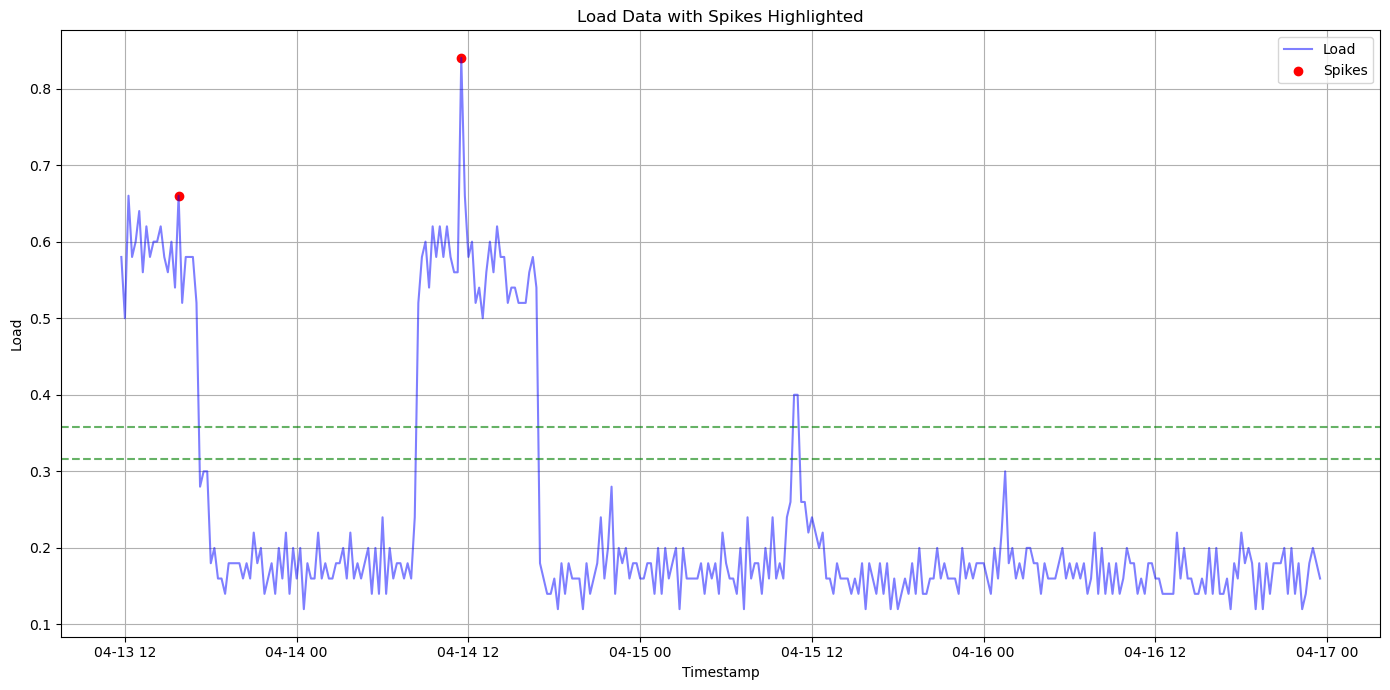

In [15]:
test_peaks = test[test['is_peak']]
# print(test_peaks)
threshold_factor = 1.1

# Calculate the average load in a window around each data point
window_size = 10  # You can adjust this window size
test_peaks['avg_load_window'] = test_peaks['Read Value'].rolling(window=window_size, min_periods=1, center=True).mean()

# Identify spikes as load values that exceed the threshold factor times the average load
test_peaks['is_spike'] = test_peaks['Read Value'] > threshold_factor * test_peaks['avg_load_window']

# # Filter out the spikes
spikes = test_peaks[test_peaks['is_spike']]

# Plotting the results for the two-week period
plt.figure(figsize=(14, 7))

# Plot the load
plt.plot(test['timestamp'], test['Read Value'], label='Load', color='blue', alpha=0.5)

plt.scatter(spikes['timestamp'], spikes['Read Value'], color='red', label='Spikes')

# Highlight spikes vertically in red
# for _, spike in spikes.iterrows():
#     plt.axvspan(spike['timestamp'] - pd.Timedelta(hours=0.5), spike['timestamp'] + pd.Timedelta(hours=0.5), color='red', alpha=0.3)

# Plot the daily average load
unique_dates = test_peaks['date'].unique()
for date in unique_dates:
    avg_load = test_peaks[test_peaks['date'] == date]['daily_avg'].iloc[0]
    plt.axhline(y=avg_load, color='green', linestyle='--', alpha=0.6)

# Formatting the plot
plt.title('Load Data with Spikes Highlighted')
plt.xlabel('Timestamp')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [ ]:
# start_idx = random.randint(0, len(df) - 2*24 - 1)
# data = df.iloc[start_idx:start_idx + 2*24].copy()

# # Combine load values of the same date and time together
# data = df.groupby('Modified Date/Time', as_index=False)['Read Value'].sum()

In [ ]:
# data = data[(data['Modified Date/Time'] >= '2023-01-01') & (data['Modified Date/Time'] <= '2024-12-31')].copy()

In [ ]:
# # Extracting features
# data['Hour'] = data['Modified Date/Time'].dt.hour
# data['DayOfWeek'] = data['Modified Date/Time'].dt.dayofweek

In [ ]:
# # Feature set for clustering
# features = data[['Hour', 'Read Value']]

In [ ]:
# # Apply K-Means clustering
# kmeans = KMeans(n_clusters=2, random_state=0, n_init=10).fit(features)
# data['Cluster'] = kmeans.labels_

In [ ]:
# data

In [ ]:
# start_idx = random.randint(0, len(data) - 14*24 - 1)
# one_week_data = data.iloc[start_idx:start_idx + 14*24].copy()

In [ ]:
# one_week_data.set_index('Modified Date/Time', inplace=True)

In [ ]:
# Calculate average load value for each day
# one_week_data['Date'] = one_week_data.index.date
# average_loads = one_week_data.groupby('Date')['Read Value'].mean()

# print(average_loads)

In [ ]:
# Initialize lists to store peak indices
# daily_peak_indices = []

# # Find daily peaks
# for date, group in one_week_data.groupby('Date'):
#     peaks, _ = find_peaks(group['Read Value'], height=average_loads[date])
#     # print(peaks, _, group.index[peaks][0], group.index[peaks][-1])
#     print(group.index[peaks])
#     if not group.index[peaks].empty:
#         daily_peak_indices.append((group.index[peaks][0], group.index[peaks][-1]))
    
# # print(daily_peak_indices)

In [ ]:
# # For remaining times, we need to find the complement intervals and mark them as red
# all_times = [ts for pair in daily_peak_indices for ts in pair]
# all_times.sort()

# # Create pairs for off-working hours from the complement of working hours
# off_working_hours_pairs = []
# for i in range(len(all_times) - 1):
#     if i % 2 == 1:  # End of a green interval to start of next green interval
#         off_working_hours_pairs.append((all_times[i], all_times[i + 1]))

# # If the first working hour does not start at the beginning of the data, mark the initial period as off-working hours
# if one_week_data.index[0] < all_times[0]:
#     off_working_hours_pairs.insert(0, (one_week_data.index[0], all_times[0]))

# # If the last working hour does not end at the end of the data, mark the final period as off-working hours
# if one_week_data.index[-1] > all_times[-1]:
#     off_working_hours_pairs.append((all_times[-1], one_week_data.index[-1]))

In [ ]:
# Calculate the mean of off-working load for each day
# off_working_means = {}
# for date, group in one_week_data.groupby(one_week_data.index.date):
#     off_working_loads = []
#     for start_time, end_time in off_working_hours_pairs:
#         if start_time.date() == date:
#             off_working_loads.extend(group.loc[start_time:end_time, 'Read Value'])
#     if off_working_loads:
#         off_working_means[date] = np.mean(off_working_loads)
#     else:
#         off_working_means[date] = None

# print("Mean of off-working load for each day:")
# for date, mean_load in off_working_means.items():
#     print(f"{date}: {mean_load}")

In [ ]:
# # Plot daily load profile
# plt.figure(figsize=(14, 7))

# plt.plot(one_week_data.index, one_week_data['Read Value'], color='black')

# # Plot the working hours in green
# for (start_time, end_time) in daily_peak_indices:
#     if pd.to_datetime(start_time).weekday() >= 5:
#         print(pd.to_datetime(start_time).weekday())# 5 and 6 correspond to Saturday and Sunday
#         plt.axvspan(start_time, end_time, color='red', alpha=0.3)
#     else:
#         print((start_time, end_time))
#         plt.axvspan(start_time, end_time, color='green', alpha=0.3)

# # Plot the off-working hours in red
# for start_time, end_time in off_working_hours_pairs:
#     plt.axvspan(start_time, end_time, color='red', alpha=0.3)


# date_string = "2020-04-20"
# try:
#     date_object = datetime.strptime(date_string, "%Y-%m-%d")
# except ValueError as e:
#     print(f"Error parsing date: {e}")
    
# plt.axhline(off_working_means[date_object.date()], color='black', linestyle='--', label='Base Load (Min)')

# plt.xlabel('Modified Date/Time')
# plt.ylabel('Read Value')
# plt.title(f'Load Profile with Working and Off-Working Hours and Base Load for {date_object.date()}')
# plt.grid(True)
# plt.show()

In [ ]:
# from scipy.signal import find_peaks

# # Reset the index of one_week_data
# one_week_data_reset_index = one_week_data.reset_index(drop=True)
# # Assuming 'test' DataFrame contains 'Modified Date/Time' and 'Read Value' columns
# average_loads = data['Read Value'].mean()

# print(0.9*average_loads)

# # Find peaks in the 'Read Value' column
# peaks, _ = find_peaks(one_week_data['Read Value'], height=0.9*average_loads)

# # Plotting the results
# plt.figure(figsize=(14, 7))

# # Plot the load values as a continuous wave
# plt.plot(one_week_data['Modified Date/Time'], one_week_data['Read Value'], color='black', label='Load Value')

# # Mark the peaks on the plot
# plt.plot(one_week_data['Modified Date/Time'].iloc[peaks], one_week_data['Read Value'].iloc[peaks], 'ro', label='Peaks', markersize = 10)

# plt.xlabel('DateTime')
# plt.ylabel('Load Value')
# plt.title('Electricity Load - Working vs Off-Working Hours (Two Weeks)')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
# one_week_data

In [ ]:
# # Initialize 'TimePeriod' column with default value
# data['TimePeriod'] = 'Off-Working Hours'

# # Set 'TimePeriod' to 'Working Hours' for peak indices
# one_week_data.loc[one_week_data.index[peaks], 'TimePeriod'] = 'Working Hours'

In [ ]:
# # Calculate the average load value during working hours and off-working hours
# average_loads = one_week_data.groupby('TimePeriod')['Read Value'].mean()
# average_loads

In [ ]:
# Find valleys between peaks
# Reset the index of one_week_data
# one_week_data = one_week_data.reset_index(drop=True)
# print(average_loads)

# average_load_value = data['Read Value'].mean()
# # Find valleys below average load
# valleys = []
# for i in range(len(peaks) - 1):
#     start_index = peaks[i]
#     end_index = peaks[i + 1]
#     if end_index - start_index > 1:  # Check if there are points between peaks
#         # Find valley between two consecutive peaks
#         valley_index = np.argmin(one_week_data['Read Value'][start_index:end_index]) + start_index
#         # Check if valley is below average load
#         if one_week_data['Read Value'][valley_index] < average_load_value:
#             valleys.append(valley_index)
# # All indices other than peaks are valleys
# # valleys = [index for index in range(len(one_week_data)) if index not in peaks]

# # Sort the valleys indices
# valleys.sort()

# Plot the continuous graph with peaks and valleys
# plt.figure(figsize=(14, 7))
# plt.plot(one_week_data['Modified Date/Time'], one_week_data['Read Value'], color='black')

# # Plot peaks
# plt.plot(one_week_data['Modified Date/Time'][peaks], one_week_data['Read Value'][peaks], 'r.', markersize=10, label='Peaks')

# # Plot valleys
# plt.plot(one_week_data['Modified Date/Time'][valleys], one_week_data['Read Value'][valleys], 'g.', markersize=10, label='Valleys')

# plt.xlabel('Modified Date/Time')
# plt.ylabel('Read Value')
# plt.title('Continuous Graph with Peaks and Valleys')
# plt.grid(True)
# plt.legend()
# plt.show()